In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maestropianomidi/maestro-v3.0.0/LICENSE
/kaggle/input/maestropianomidi/maestro-v3.0.0/maestro-v3.0.0.csv
/kaggle/input/maestropianomidi/maestro-v3.0.0/README
/kaggle/input/maestropianomidi/maestro-v3.0.0/maestro-v3.0.0.json
/kaggle/input/maestropianomidi/maestro-v3.0.0/2017/MIDI-Unprocessed_062_PIANO062_MID--AUDIO-split_07-07-17_Piano-e_2-07_wav--2.midi
/kaggle/input/maestropianomidi/maestro-v3.0.0/2017/MIDI-Unprocessed_060_PIANO060_MID--AUDIO-split_07-07-17_Piano-e_2-04_wav--4.midi
/kaggle/input/maestropianomidi/maestro-v3.0.0/2017/MIDI-Unprocessed_045_PIANO045_MID--AUDIO-split_07-06-17_Piano-e_2-01_wav--2.midi
/kaggle/input/maestropianomidi/maestro-v3.0.0/2017/MIDI-Unprocessed_081_PIANO081_MID--AUDIO-split_07-09-17_Piano-e_2_-02_wav--1.midi
/kaggle/input/maestropianomidi/maestro-v3.0.0/2017/MIDI-Unprocessed_058_PIANO058_MID--AUDIO-split_07-07-17_Piano-e_2-02_wav--4.midi
/kaggle/input/maestropianomidi/maestro-v3.0.0/2017/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-

In [ ]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 59.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592292 sha256=d3cb81dc02fad3a255ffaeb175024c598fd64db18c029c6fb5592459aa8217e4
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
!pip install midiutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54567 sha256=cd4058685390893afcda79036549fff909661509048bda43b2bb09ac2471393f
  Stored in directory: /root/.cache/pip/wheels/af/43/4a/00b5e4f2fe5e2cd6e92b461995a3a97a2cebb30ab5783501b0
Successfully built midiutil


In [ ]:
import os
import pretty_midi
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define dataset path
dataset_path = "/kaggle/input/maestropianomidi"

# Verify dataset path
if os.path.exists(dataset_path):
    print("Dataset path exists.")
    midi_files = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.midi') or file.endswith('.mid'):
                midi_files.append(os.path.join(root, file))
    print(f"Total MIDI files found: {len(midi_files)}")
else:
    print("Dataset path does not exist!")


Dataset path exists.
Total MIDI files found: 1276


In [ ]:
import warnings

# Enhanced function with error handling
def midi_to_events_safe(file_path):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress warnings from pretty_midi
            midi = pretty_midi.PrettyMIDI(file_path)

        events = []
        for instrument in midi.instruments:
            for note in instrument.notes:
                events.append({
                    "type": "NOTE_ON",
                    "pitch": note.pitch,
                    "velocity": note.velocity,
                    "time": note.start
                })
                events.append({
                    "type": "NOTE_OFF",
                    "pitch": note.pitch,
                    "time": note.end
                })
        events.sort(key=lambda x: x["time"])
        return events

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

# Convert events to tokens (unchanged)
def events_to_tokens(events):
    tokens = []
    for event in events:
        if event["type"] == "NOTE_ON":
            tokens.append(f"NOTE_ON_{event['pitch']}")
            tokens.append(f"VELOCITY_{event['velocity']}")
        elif event["type"] == "NOTE_OFF":
            tokens.append(f"NOTE_OFF_{event['pitch']}")
    return tokens

# Process a subset of files
all_tokens = []
valid_files = 0

for midi_file in midi_files[:50]:  # Process the first 50 files
    events = midi_to_events_safe(midi_file)
    if events:  # Only process files that returned events
        tokens = events_to_tokens(events)
        all_tokens.append(tokens)
        valid_files += 1

print(f"Successfully processed {valid_files} MIDI files into tokens.")


Successfully processed 50 MIDI files into tokens.


In [ ]:
# Tokenizer: Create a vocabulary of unique tokens
unique_tokens = set(token for tokens in all_tokens for token in tokens)
token_to_index = {token: idx for idx, token in enumerate(unique_tokens)}
index_to_token = {idx: token for token, idx in token_to_index.items()}

# Convert tokens to indices
def tokens_to_indices(tokens):
    return [token_to_index[token] for token in tokens]

indexed_sequences = [tokens_to_indices(tokens) for tokens in all_tokens]

# Create input-output pairs
sequence_length = 100
X, y = [], []
for sequence in indexed_sequences:
    for i in range(len(sequence) - sequence_length):
        X.append(sequence[i:i + sequence_length])
        y.append(sequence[i + sequence_length])

X = np.array(X)
y = np.array(y)

print(f"Prepared dataset with {X.shape[0]} sequences.")


Prepared dataset with 620734 sequences.


In [ ]:
def positional_encoding(seq_length, embed_dim):
    """Generate positional encodings for the sequence."""
    angles = np.arange(seq_length)[:, np.newaxis] / np.power(10000, (2 * (np.arange(embed_dim) // 2)) / np.float32(embed_dim))
    angles[:, 0::2] = np.sin(angles[:, 0::2])  # Apply sin to even indices
    angles[:, 1::2] = np.cos(angles[:, 1::2])  # Apply cos to odd indices
    pos_encoding = angles[np.newaxis, ...]  # Add batch dimension
    return tf.cast(pos_encoding, dtype=tf.float32)

# Example
seq_length = 100
embed_dim = 256
positional_encodings = positional_encoding(seq_length, embed_dim)
print("Positional encoding shape:", positional_encodings.shape)  # Should be [1, 100, 256]


Positional encoding shape: (1, 100, 256)


In [ ]:
# Create input-output pairs
sequence_length = 100
X, y = [], []
for sequence in indexed_sequences:
    for i in range(len(sequence) - sequence_length):
        X.append(sequence[i:i + sequence_length])
        y.append(sequence[i + 1:i + sequence_length + 1])  # Shift by 1 to match output shape

X = np.array(X)
y = np.array(y)

# Adjust y shape to match the expected output shape (batch_size, sequence_length)
y = np.expand_dims(y, -1)  # Adds an extra dimension for the target tokens, making it (batch_size, sequence_length, 1)

# Print the shape to check
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (620734, 100), y shape: (620734, 100, 1)


In [ ]:
def build_transformer_model(vocab_size, max_len):
    inputs = layers.Input(shape=(max_len,), dtype="int32")

    # Token embedding layer
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=256)(inputs)

    # Positional encoding: Add a 256-dimensional positional encoding
    positional_encoding = tf.range(max_len)[tf.newaxis, :]  # Shape (1, max_len)
    positional_encoding = layers.Embedding(input_dim=max_len, output_dim=256)(positional_encoding)  # Shape (1, max_len, 256)

    # Add the positional encoding to the embedding
    embeddings = embedding + positional_encoding

    # Transformer encoder layers
    x = embeddings
    for _ in range(4):  # Number of Transformer layers
        x = layers.MultiHeadAttention(num_heads=8, key_dim=256)(x, x)
        x = layers.LayerNormalization()(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.LayerNormalization()(x)

    # Output layer for token prediction (vocab_size is the size of the vocabulary)
    outputs = layers.Dense(vocab_size, activation="softmax")(x)

    return Model(inputs, outputs)

# Build and compile the model
vocab_size = len(unique_tokens)  # The size of the vocabulary (ensure this is correctly calculated)
sequence_length = 100  # Sequence length
model = build_transformer_model(vocab_size, sequence_length)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

print(model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 256)  │     75,264 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 256)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 256)  │  2,103,552 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 100, 256)  │        512 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100, 512)  │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 512)  │  4,200,960 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100, 512)  │    262,656 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 512)  │  4,200,960 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100, 512)  │    262,656 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 512)  │  4,200,960 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 512)  │      1,024 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 100, 512)  │    262,656 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 15,859,750 (60.50 MB)

 Trainable params: 15,859,750 (60.50 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/10


I0000 00:00:1734023437.927728      91 service.cc:145] XLA service 0x794b7800b2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734023437.927780      91 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734023437.927784      91 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1734023438.593593      91 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734023445.134708     134 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_139', 228 bytes spill stores, 228 bytes spill loads

I0000 00:00:1734023452.048565     135 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_25', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:173402

7759/7760 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 5.2234

W0000 00:00:1734025138.508035      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734025145.327692     183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_149', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734025147.681259     181 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_139', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1734025150.239032     180 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_155', 228 bytes spill stores, 228 bytes spill loads

I0000 00:00:1734025155.700318     180 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_147', 16 bytes spill stores, 8 bytes spill loads

I0000 00:00:1734025156.519931     18

7760/7760 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 5.2234

W0000 00:00:1734025161.436939      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1734025302.794497      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1734025306.664285     257 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_26', 228 bytes spill stores, 228 bytes spill loads



7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1877s 238ms/step - loss: 5.2234 - val_loss: 5.2145
Epoch 2/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1856s 239ms/step - loss: 5.2125 - val_loss: 5.2129
Epoch 3/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1864s 240ms/step - loss: 5.2122 - val_loss: 5.2142
Epoch 4/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1852s 239ms/step - loss: 5.2122 - val_loss: 5.2153
Epoch 5/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1853s 239ms/step - loss: 5.2117 - val_loss: 5.2142
Epoch 6/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1852s 239ms/step - loss: 5.2117 - val_loss: 5.2146
Epoch 7/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1854s 239ms/step - loss: 5.2115 - val_loss: 5.2134
Epoch 8/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1863s 240ms/step - loss: 5.2112 - val_loss: 5.2136
Epoch 9/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1867s 241ms/step - loss: 5.2116 - val_loss: 5.2145
Epoch 10/10
7760/7760 ━━━━━━━━━━━━━━━━━━━━ 1864s 240ms/step - loss: 5.2120 - val_loss: 5.2133


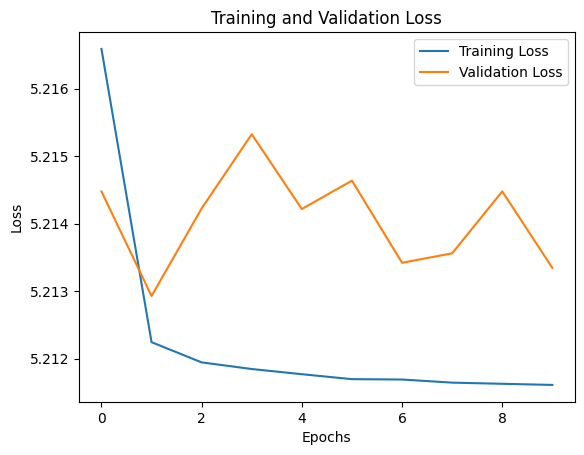

In [ ]:
# Train the model
batch_size = 64  # You can adjust the batch size based on your available memory
epochs = 10  # You can adjust the number of epochs

# Train the model
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

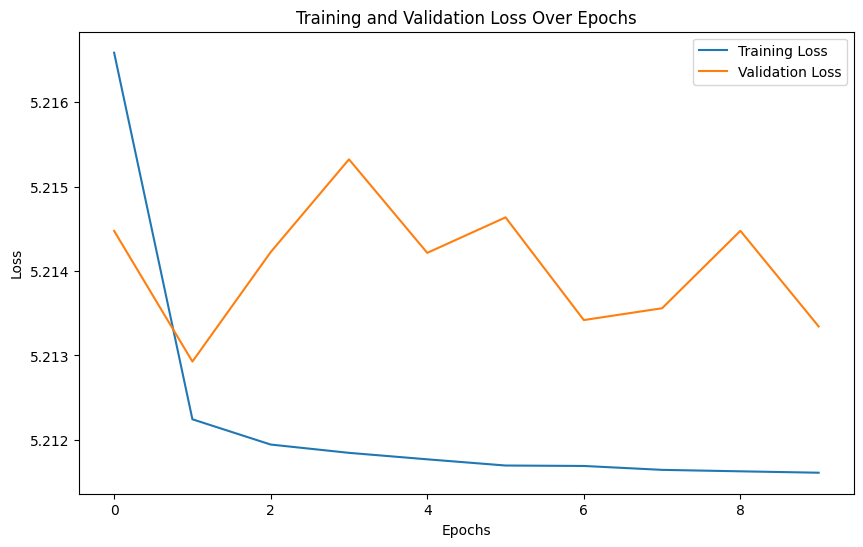

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training and validation loss
def plot_training_history(history):
    """
    Plot the training and validation loss over epochs.

    Args:
        history (History): The training history object returned by the model's fit method.
    """
    plt.figure(figsize=(10, 6))

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    # Add labels and title
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()

# Call this after model training to visualize the loss
plot_training_history(history)

In [ ]:
# Save the model with the correct extension
model.save('/kaggle/working/my_transformer_model.keras')

In [ ]:
model.save("music_transformer_model_2.keras")
print("Model saved as 'music_transformer_model_2.keras'")

Model saved as 'music_transformer_model_2.keras'


In [ ]:
import os
print(os.listdir())  # List all files in the current directory


['my_transformer_model.keras', 'music_transformer_model_2.keras', '.virtual_documents']


In [ ]:
from IPython.display import FileLink

# Provide a download link
FileLink("music_transformer_model_2.keras")


/kaggle/working/music_transformer_model_2.keras

In [ ]:
import numpy as np
from midiutil import MIDIFile
import os

def generate_and_save_diverse_music_tt2(
    model,
    initial_sequences,
    num_pieces,
    length,
    top_k=10,
    temperature=1,
    exclude_top=1,
    output_dir="generated_music_diverse"
):
    os.makedirs(output_dir, exist_ok=True)

    for i in range(num_pieces):
        # Start with a unique seed sequence
        seed_sequence = initial_sequences[i % len(initial_sequences)]
        generated_sequence = seed_sequence.copy()

        for _ in range(length):
            # Model prediction
            input_sequence = np.array([generated_sequence[-len(seed_sequence):]])
            predictions = model.predict(input_sequence, verbose=0)[0, -1]

            # Apply temperature scaling
            scaled_predictions = np.log(predictions + 1e-8) / temperature
            probabilities = np.exp(scaled_predictions)
            probabilities /= np.sum(probabilities)

            # Exclude top-N predictions
            sorted_indices = np.argsort(probabilities)[::-1]
            allowed_indices = sorted_indices[exclude_top:]
            adjusted_probabilities = probabilities[allowed_indices]
            adjusted_probabilities /= np.sum(adjusted_probabilities)

            # Sample from adjusted probabilities
            next_note = np.random.choice(allowed_indices, p=adjusted_probabilities)

            # Append to the generated sequence
            generated_sequence.append(next_note)

        # Save the generated sequence as a MIDI file
        midi_file = MIDIFile(1)
        midi_file.addTempo(0, 0, 120)

        time = 0
        for pitch in generated_sequence:
            if 0 <= pitch <= 127:  # Valid MIDI note range
                midi_file.addNote(0, 0, pitch, time, 1, 100)
                time += 1

        output_path = os.path.join(output_dir, f"Generated_Piece_{i + 1}.mid")
        with open(output_path, "wb") as f:
            midi_file.writeFile(f)

    print(f"Generated {num_pieces} diverse pieces. Check the '{output_dir}' folder.")
